# Modèle 2 - Concaténation par heure

Suite à l'echec du modèle 1 à cause du bruit, ce nouveau modèle a été généré avec concatenation de features. Le dataset étant plus light, les modèles vont être entrainés sur ce notebook, optimisé, evalués et explorés ici

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error#, mean_squared_log_error

%matplotlib inline

## Preprocessing

In [94]:
df = pd.read_csv("dataset/merged/model2_dataset.csv")
df.dropna(axis=1, how="all", inplace=True)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278083 entries, 0 to 278082
Data columns (total 7 columns):
WEEK                   278083 non-null int64
DAY_OF_WEEK            278083 non-null int64
FL_HOUR                278083 non-null int64
UNIQUE_CARRIER         278083 non-null object
ORIGIN_AIRPORT_RANK    278083 non-null float64
DEP_DELAY              277654 non-null float64
NUM_FLIGHT             278083 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 14.9+ MB


In [96]:
df["DEP_DELAY"].describe()

count    277654.000000
mean          8.395564
std          24.861186
min         -60.000000
25%          -3.000000
50%           2.285714
75%          11.757371
max        1616.000000
Name: DEP_DELAY, dtype: float64

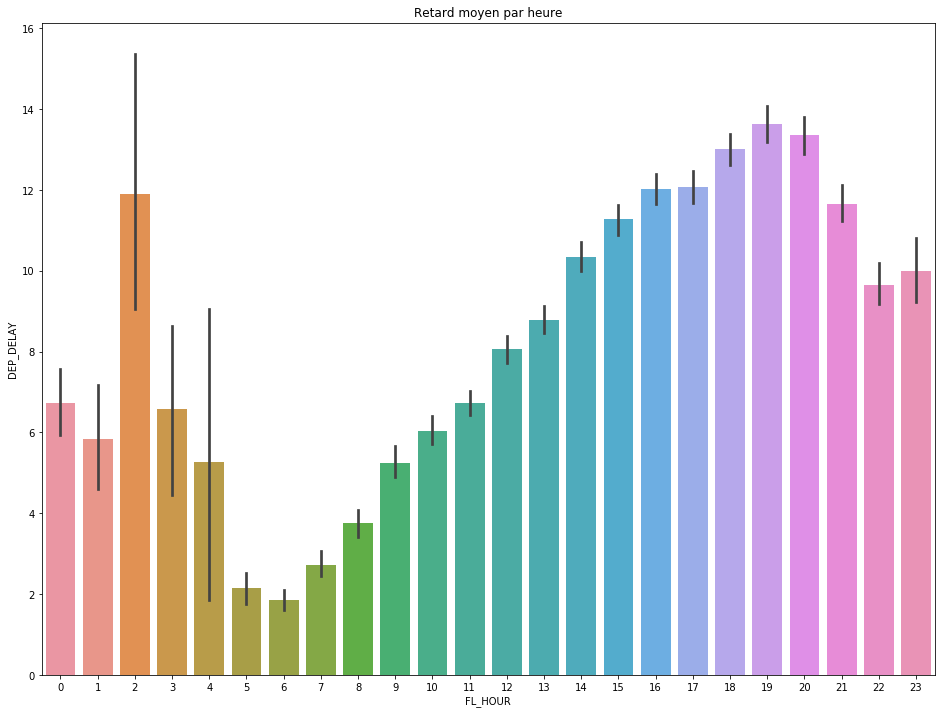

In [97]:
plt.figure(figsize=(16,12))
ax = sns.barplot(x="FL_HOUR", y="DEP_DELAY", data=df)
plt.title("Retard moyen par heure")
plt.savefig("img/delay_hour.png")
plt.show()

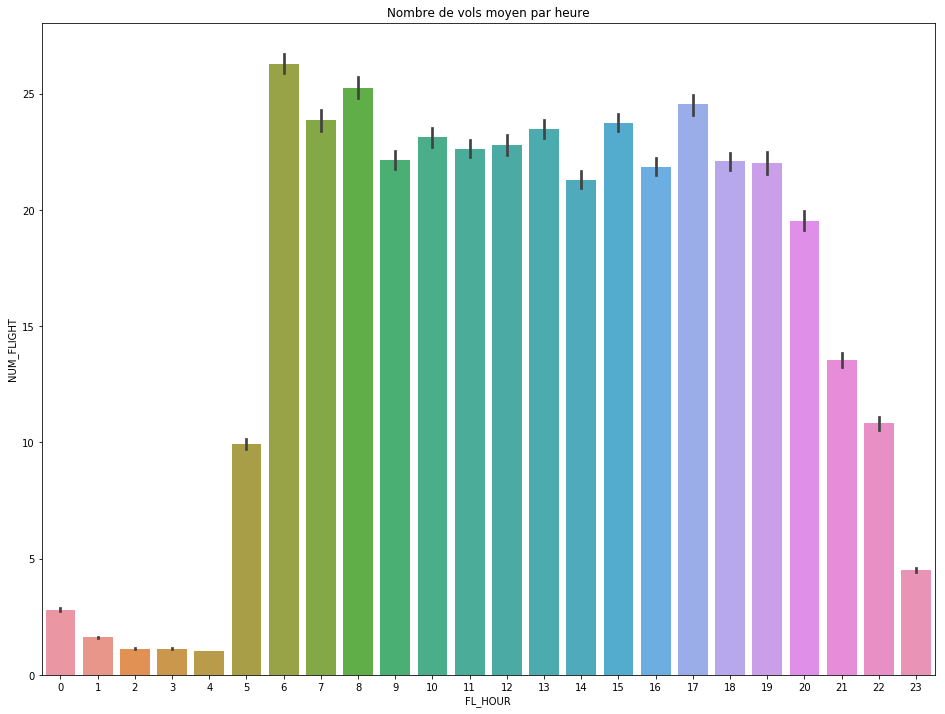

In [98]:
plt.figure(figsize=(16,12))
ax = sns.barplot(x="FL_HOUR", y="NUM_FLIGHT", data=df)
plt.title("Nombre de vols moyen par heure")
plt.savefig("img/nb_flight_hour.png")
plt.show()

OHE des features catégoriques / non linéaires

In [99]:
df = pd.concat([df, pd.get_dummies(df["UNIQUE_CARRIER"])], axis=1)
df = pd.concat([df, pd.get_dummies(df["DAY_OF_WEEK"], prefix="DAY_")], axis=1)
df = pd.concat([df, pd.get_dummies(df["WEEK"], prefix="WEEK_")], axis=1)

df.drop("UNIQUE_CARRIER", axis=1, inplace = True)
df.drop("DAY_OF_WEEK", axis=1, inplace = True)
df.drop("WEEK", axis=1, inplace = True)

In [100]:
df_OHE = df.copy()
df_OHE = pd.concat([df_OHE, pd.get_dummies(df["ORIGIN_AIRPORT_RANK"], prefix="RANK_")], axis=1)
df_OHE.drop("ORIGIN_AIRPORT_RANK", axis=1, inplace = True)

Les heures sans vol ont une moyenne nulle, du coup je supprime ces enregristrements

In [101]:
df["DEP_DELAY"].isnull().sum()

429

In [102]:
df = df[df["DEP_DELAY"].notnull()]
df_OHE = df_OHE[df_OHE["DEP_DELAY"].notnull()]

## Préparation des modèles

In [103]:
X = df.drop("DEP_DELAY", axis=1)
y = df["DEP_DELAY"]

X_OHE = df_OHE.drop("DEP_DELAY", axis=1)
y_OHE = df_OHE["DEP_DELAY"]

In [105]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X_scale_OHE = scaler.fit_transform(X_OHE)

joblib.dump(scaler, "prod/scaler.pkl")

['prod/scaler.pkl']

on fixe random state par la suite pour splitter les 2 datasets de la même façon pour comparer les outputs

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=42)
X_train_OHE, X_test_OHE, y_train_OHE, y_test_OHE = train_test_split(X_scale_OHE, y_OHE, test_size=0.2, random_state=42)

## Mise en place des modèles

In [14]:
from sklearn.linear_model import SGDRegressor

### SGDR sans OHE sur les rang des aéroports

In [15]:
from sklearn.model_selection import ParameterGrid

params = [
    {
    "loss" : ["huber"],
    "penalty" : [None, 'l2', 'l1'],
    "max_iter": [3, 5, 10]
    },
    {
    "loss" : ["huber"],
    "penalty" : ['elasticnet'],
    "l1_ratio" : [0.15, 0.50, 0.85],
    "max_iter": [3, 5, 10]
    }]

for param in ParameterGrid(params):
    model = SGDRegressor(**param)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    print("SGD_Regressor ({}) : MSE {:.4f}, MAE {:.4f}\n".format(param, MSE, MAE) )

SGD_Regressor ({'loss': 'huber', 'max_iter': 3, 'penalty': None}) : MSE 658.2074, MAE 11.5779

SGD_Regressor ({'loss': 'huber', 'max_iter': 3, 'penalty': 'l2'}) : MSE 658.5255, MAE 11.5828

SGD_Regressor ({'loss': 'huber', 'max_iter': 3, 'penalty': 'l1'}) : MSE 658.7348, MAE 11.5897

SGD_Regressor ({'loss': 'huber', 'max_iter': 5, 'penalty': None}) : MSE 656.1571, MAE 11.4761

SGD_Regressor ({'loss': 'huber', 'max_iter': 5, 'penalty': 'l2'}) : MSE 656.5018, MAE 11.4841

SGD_Regressor ({'loss': 'huber', 'max_iter': 5, 'penalty': 'l1'}) : MSE 656.6368, MAE 11.4920

SGD_Regressor ({'loss': 'huber', 'max_iter': 10, 'penalty': None}) : MSE 652.6600, MAE 11.3115

SGD_Regressor ({'loss': 'huber', 'max_iter': 10, 'penalty': 'l2'}) : MSE 653.3205, MAE 11.3255

SGD_Regressor ({'loss': 'huber', 'max_iter': 10, 'penalty': 'l1'}) : MSE 653.4927, MAE 11.3335

SGD_Regressor ({'l1_ratio': 0.15, 'loss': 'huber', 'max_iter': 3, 'penalty': 'elasticnet'}) : MSE 658.4837, MAE 11.5838

SGD_Regressor ({'l1_r

In [16]:
param = {'loss': 'huber', 'max_iter': 10, 'penalty': None}
model = SGDRegressor(**param)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
print(MSE, MAE)

652.738005517 11.3116182735


### SGDR avec OHE sur les rang des aéroports

In [14]:
from sklearn.model_selection import ParameterGrid

params = [
    {
    "loss" : ["huber"],
    "penalty" : [None, 'l2', 'l1'],
    "max_iter": [3, 5, 10]
    },
    {
    "loss" : ["huber"],
    "penalty" : ['elasticnet'],
    "l1_ratio" : [0.15, 0.50, 0.85],
    "max_iter": [3, 5, 10]
    }]

for param in ParameterGrid(params):
    model = SGDRegressor(**param)
    model.fit(X_train_OHE, y_train_OHE)

    y_pred_OHE = model.predict(X_test_OHE)

    MSE = mean_squared_error(y_test_OHE, y_pred_OHE)
    MAE = mean_absolute_error(y_test_OHE, y_pred_OHE)
    print("SGD_Regressor ({}) : MSE {:.4f}, MAE {:.4f}\n".format(param, MSE, MAE) )

SGD_Regressor ({'loss': 'huber', 'max_iter': 3, 'penalty': None}) : MSE 659.1134, MAE 11.4888

SGD_Regressor ({'loss': 'huber', 'max_iter': 3, 'penalty': 'l2'}) : MSE 659.2655, MAE 11.4936

SGD_Regressor ({'loss': 'huber', 'max_iter': 3, 'penalty': 'l1'}) : MSE 659.6626, MAE 11.5010

SGD_Regressor ({'loss': 'huber', 'max_iter': 5, 'penalty': None}) : MSE 656.2138, MAE 11.3778

SGD_Regressor ({'loss': 'huber', 'max_iter': 5, 'penalty': 'l2'}) : MSE 656.6678, MAE 11.3858

SGD_Regressor ({'loss': 'huber', 'max_iter': 5, 'penalty': 'l1'}) : MSE 656.8696, MAE 11.3938

SGD_Regressor ({'loss': 'huber', 'max_iter': 10, 'penalty': None}) : MSE 652.2052, MAE 11.2355

SGD_Regressor ({'loss': 'huber', 'max_iter': 10, 'penalty': 'l2'}) : MSE 652.6749, MAE 11.2482

SGD_Regressor ({'loss': 'huber', 'max_iter': 10, 'penalty': 'l1'}) : MSE 652.8597, MAE 11.2558

SGD_Regressor ({'l1_ratio': 0.15, 'loss': 'huber', 'max_iter': 3, 'penalty': 'elasticnet'}) : MSE 659.3410, MAE 11.4949

SGD_Regressor ({'l1_r

In [17]:
param_OHE = {'loss': 'huber', 'max_iter': 10, 'penalty': None}
model_OHE = SGDRegressor(**param_OHE)
model_OHE.fit(X_train_OHE, y_train_OHE)

y_pred_OHE = model_OHE.predict(X_test_OHE)

MSE = mean_squared_error(y_test_OHE, y_pred_OHE)
MAE = mean_absolute_error(y_test_OHE, y_pred_OHE)
print(MSE, MAE)

652.163156979 11.2352670918


La version OHE est plus accurate, on la garde pour entrainer le boosting

### Boosting sur version OHE

In [18]:
from sklearn.ensemble import AdaBoostRegressor

In [27]:
best_params_single_SGDR = {'loss': 'huber', 'max_iter': 10, 'penalty': None}

params = [
{
    "base_estimator" : [SGDRegressor(**best_params_single_SGDR)],
    "n_estimators" : [2, 5, 10, 20],
    "loss" : ['linear', 'square', 'exponential']
}]

for param in ParameterGrid(params):
    booster = AdaBoostRegressor(**param)
    booster.fit(X_train_OHE, y_train_OHE)

    y_pred_OHE_booster = booster.predict(X_test_OHE)
    MSE = mean_squared_error(y_test_OHE, y_pred_OHE_booster)
    MAE = mean_absolute_error(y_test_OHE, y_pred_OHE_booster)

    print("Booster ({}) : MSE {:.4f}, MAE {:.4f}\n".format(param, MSE, MAE) )

Booster ({'base_estimator': SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='huber', max_iter=10, n_iter=None, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False), 'loss': 'linear', 'n_estimators': 2}) : MSE 652.3083, MAE 11.2374

Booster ({'base_estimator': SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='huber', max_iter=10, n_iter=None, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False), 'loss': 'linear', 'n_estimators': 5}) : MSE 648.7333, MAE 11.2433

Booster ({'base_estimator': SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='huber', max_iter=10, n_iter=None, pen

In [19]:
final_param = {'base_estimator': SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
               fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
               loss='huber', max_iter=10, n_iter=None, penalty=None, power_t=0.25,
               random_state=None, shuffle=True, tol=None, verbose=0,
               warm_start=False), 'loss': 'exponential', 'n_estimators': 5}

booster = AdaBoostRegressor(**final_param)
booster.fit(X_train_OHE, y_train_OHE)

y_pred_OHE_booster = booster.predict(X_test_OHE)
MSE = mean_squared_error(y_test_OHE, y_pred_OHE_booster)
MAE = mean_absolute_error(y_test_OHE, y_pred_OHE_booster)

print(MSE, MAE)

648.423575374 11.2410911782


On a donc le modèle fitté que l'on peut explorer

## Comparaison des predictions

In [21]:
start = 100
for x, y, z, a in zip(y_test[start:start+10], y_pred[start:start+10], y_pred_OHE[start:start+10], y_pred_OHE_booster[start:start+10]):
    print(x , "\t", y, "\t", z, "\t", a)

6.92857142857 	 3.08073220371 	 2.81503839816 	 3.23048832163
3.0 	 -0.0623232451083 	 -1.5842132886 	 -1.24019784663
1.0 	 2.2974337976 	 2.27084376283 	 2.63009784529
-5.75 	 -2.98421966672 	 -4.31915752562 	 -3.94379332501
-3.16666666667 	 -1.06596435909 	 -1.28792099435 	 -0.977124013072
0.75 	 2.37899190508 	 1.05304724378 	 1.51369719699
-4.0 	 1.77310115381 	 2.11652381214 	 2.58339319792
10.5 	 0.891037698841 	 -0.533124160999 	 -0.272631935631
-0.722222222222 	 3.99945562843 	 4.45114498808 	 4.71973487739
16.4571428571 	 2.11999668471 	 1.87759592375 	 2.07018722216


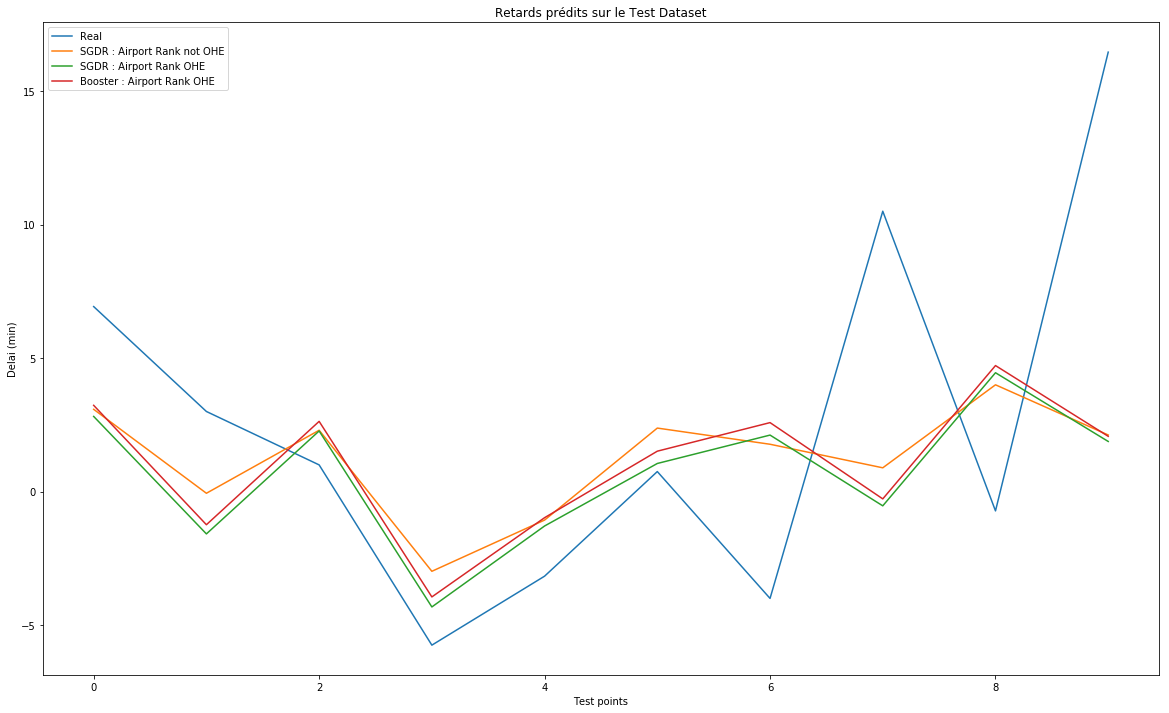

In [23]:
width = 10
plt.figure(figsize=(20,12))
plt.plot(range(width), y_test[start:start+width], label="Real")
plt.plot(range(width), y_pred[start:start+width], label="SGDR : Airport Rank not OHE")
plt.plot(range(width), y_pred_OHE[start:start+width], label="SGDR : Airport Rank OHE")
plt.plot(range(width), y_pred_OHE_booster[start:start+width], label="Booster : Airport Rank OHE")
plt.legend()
plt.ylabel("Delai (min)")
plt.xlabel("Test points")
plt.title("Retards prédits sur le Test Dataset")
plt.savefig("img/predict_zoom_in.png")
plt.show()

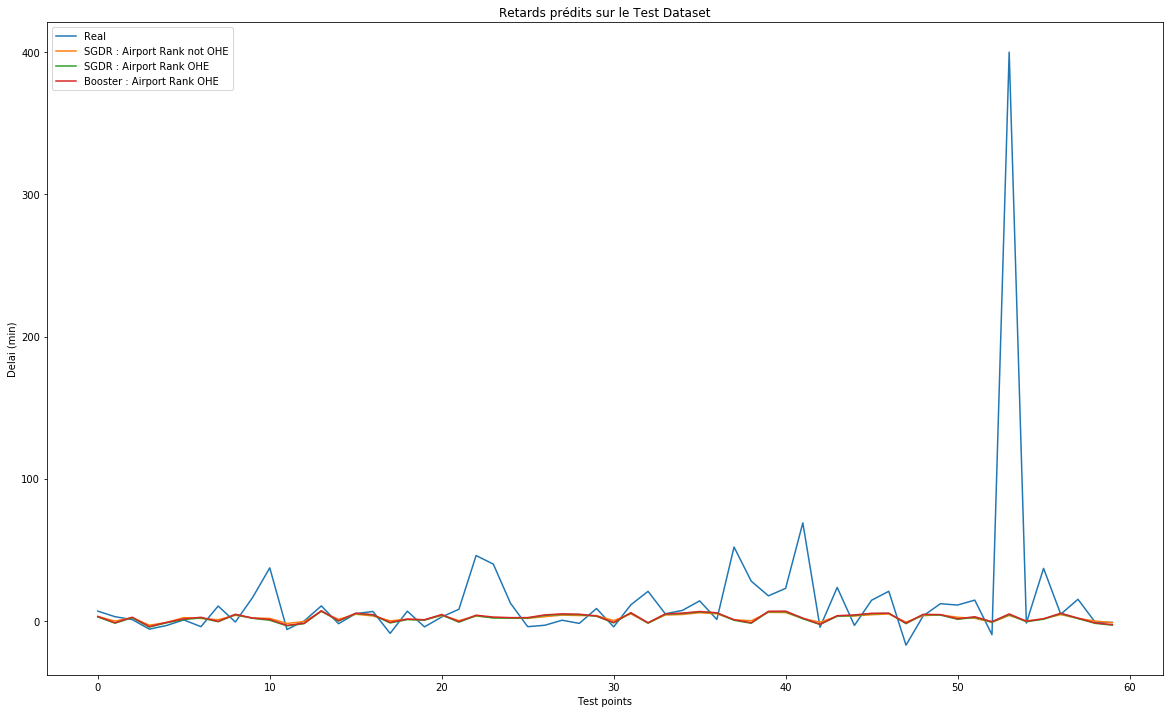

In [24]:
width = 60
plt.figure(figsize=(20,12))
plt.plot(range(width), y_test[start:start+width], label="Real")
plt.plot(range(width), y_pred[start:start+width], label="SGDR : Airport Rank not OHE")
plt.plot(range(width), y_pred_OHE[start:start+width], label="SGDR : Airport Rank OHE")
plt.plot(range(width), y_pred_OHE_booster[start:start+width], label="Booster : Airport Rank OHE")
plt.legend()
plt.ylabel("Delai (min)")
plt.xlabel("Test points")
plt.title("Retards prédits sur le Test Dataset")
plt.savefig("img/predict_zoom_out.png")
plt.show()

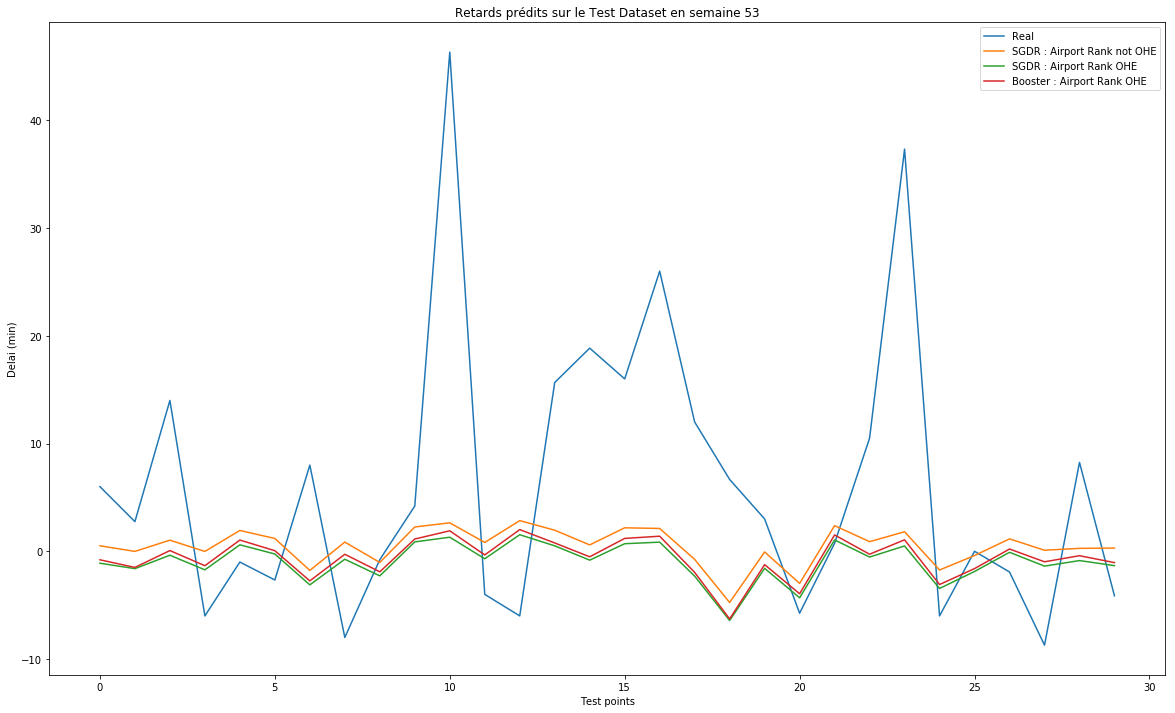

In [28]:
column = list(df_OHE).index("WEEK__53")
index_list = np.where(X_test_OHE[:,column] == 1)[0][:30]
x_range = len(index_list)

plt.figure(figsize=(20,12))
plt.plot(range(x_range), y_test_OHE.reset_index(drop=True).iloc[index_list], label="Real")
plt.plot(range(x_range), y_pred[index_list], label="SGDR : Airport Rank not OHE")
plt.plot(range(x_range), y_pred_OHE[index_list], label="SGDR : Airport Rank OHE")
plt.plot(range(x_range), y_pred_OHE_booster[index_list], label="Booster : Airport Rank OHE")
plt.legend()
plt.ylabel("Delai (min)")
plt.xlabel("Test points")
plt.title("Retards prédits sur le Test Dataset en semaine 53")
plt.savefig("img/predict_december.png")
plt.show()

On remarque que les tendances sont conservés mais les gros écarts ne sont pas bien "estimés". A cause du lissage par la moyenne et d'un modèle juste linéaire, on underfit le dataset

# Exploration du modele

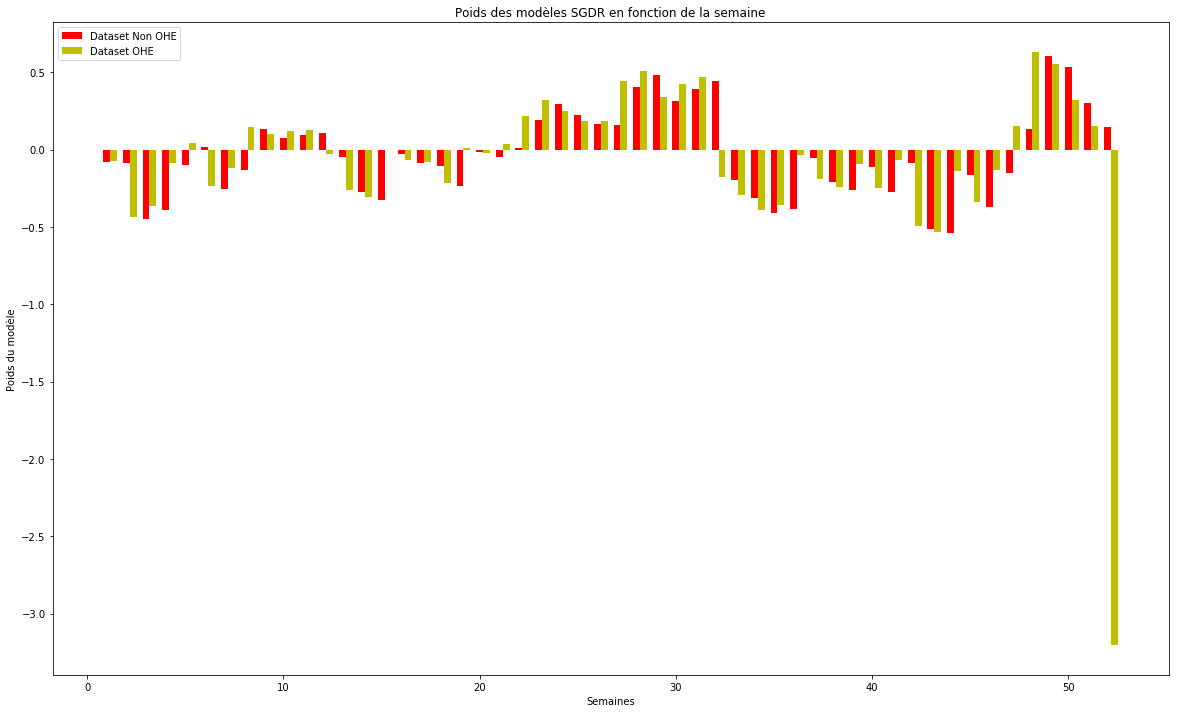

In [34]:
import seaborn as sns 
import pickle

width = 0.35
x = []
x2 = []
y = []
y2 = []
for key, key_ohe, value in zip(model.coef_, model_OHE.coef_, list(df)):
    if value.startswith("WEEK_"):
        x.append(int(value[6:]))
        x2.append(int(value[6:])+width)
        y.append(key)
        y2.append(key_ohe)


# plt.figure(figsize=(20,12))
fig, ax = plt.subplots(figsize=(20,12))
rects1 = ax.bar(x, y, width, color='r', label="Dataset Non OHE")
rects2 = ax.bar(x2, y2, width, color='y', label="Dataset OHE")
plt.legend()
# plt.bar(x, y)
# plt.xticks(x_pos, people) 
plt.xlabel("Semaines")
plt.ylabel('Poids du modèle')
plt.title("Poids des modèles SGDR en fonction de la semaine")
plt.savefig("img/weight_week.png")
plt.show()

On remarque des poids forts pour les semaines d'été et proche de noel (sauf le modele avec OHE qui est très différent en semaine 53)

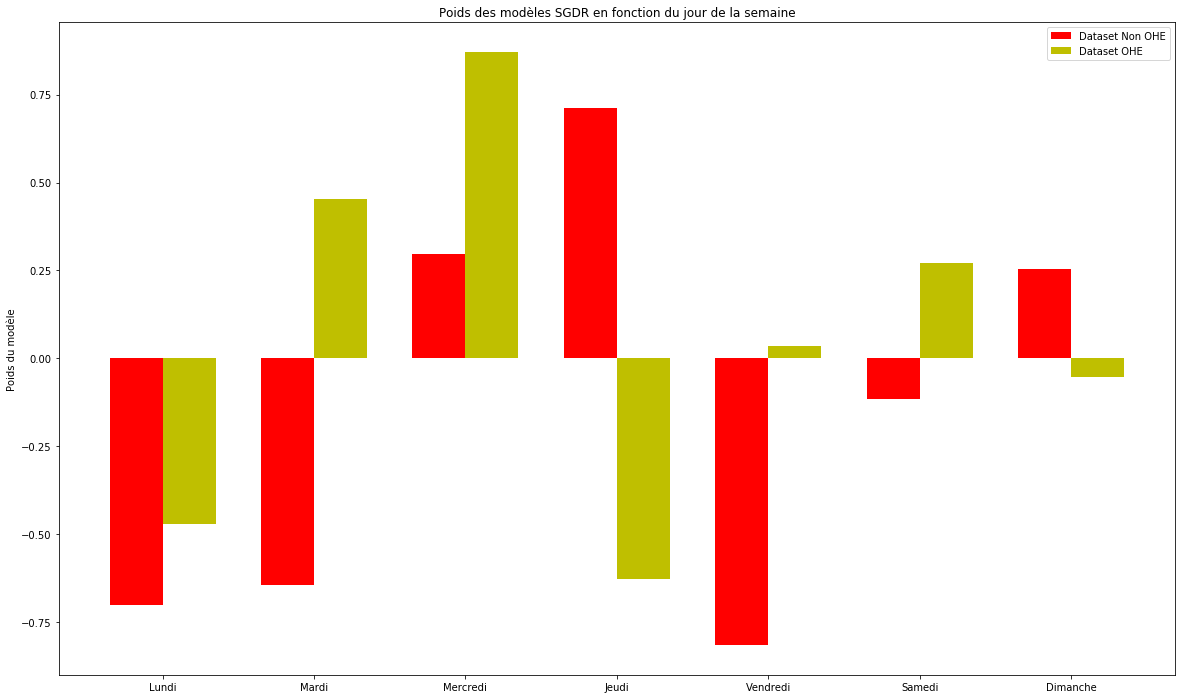

In [40]:
width = 0.35
x = []
x2 = []
y = []
y2 = []
mid = []
for key, key_ohe, value in zip(model.coef_, model_OHE.coef_, list(df)):
    if value.startswith("DAY_"):
        x.append(int(value[5:]))
        x2.append(int(value[5:])+width)
        mid.append(int(value[5:])+width/2)
        y.append(key)
        y2.append(key_ohe)

label = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]
# plt.figure(figsize=(20,12))
fig, ax = plt.subplots(figsize=(20,12))
rects1 = ax.bar(x, y, width, color='r', label="Dataset Non OHE")
rects2 = ax.bar(x2, y2, width, color='y', label="Dataset OHE")
ax.set_xticks(mid)
ax.set_xticklabels(label)
plt.legend()
plt.xlabel("")
plt.ylabel('Poids du modèle')
plt.title("Poids des modèles SGDR en fonction du jour de la semaine")
plt.savefig("img/weight_day.png")
plt.show()

Par jour, on remarque des pics d'activités le mardi/mercredi et week end

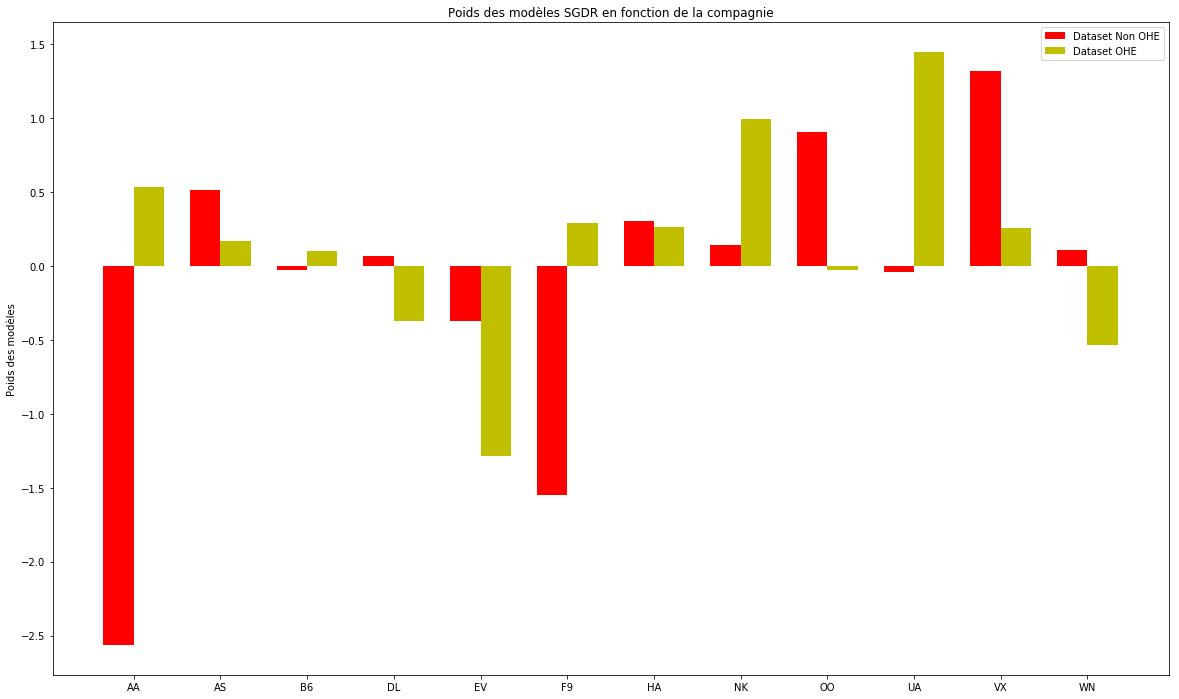

In [41]:
width = 0.35
label = []
x = []
x2 = []
y = []
y2 = []
mid=[]
a = 0
for key, key_ohe, value in zip(model.coef_, model_OHE.coef_, list(df)):
    if len(value) == 2:
        label.append(value)
        y.append(key)
        y2.append(key_ohe)
        x.append(a)
        x2.append(a+width)
        mid.append(a+width/2)
        a += 1

# plt.figure(figsize=(20,12))
fig, ax = plt.subplots(figsize=(20,12))
rects1 = ax.bar(x, y, width, color='r', label="Dataset Non OHE")
rects2 = ax.bar(x2, y2, width, color='y', label="Dataset OHE")
ax.set_xticks(mid)
ax.set_xticklabels(label)
plt.legend()
plt.ylabel('Poids des modèles')
plt.title("Poids des modèles SGDR en fonction de la compagnie")
plt.savefig("img/weight_compagnie.png")
plt.show()

Les poids associés aux aéroports sont très différents, la variation de poids compense d'autres paramètres (car les 2 MAE sont très proche tout de même)

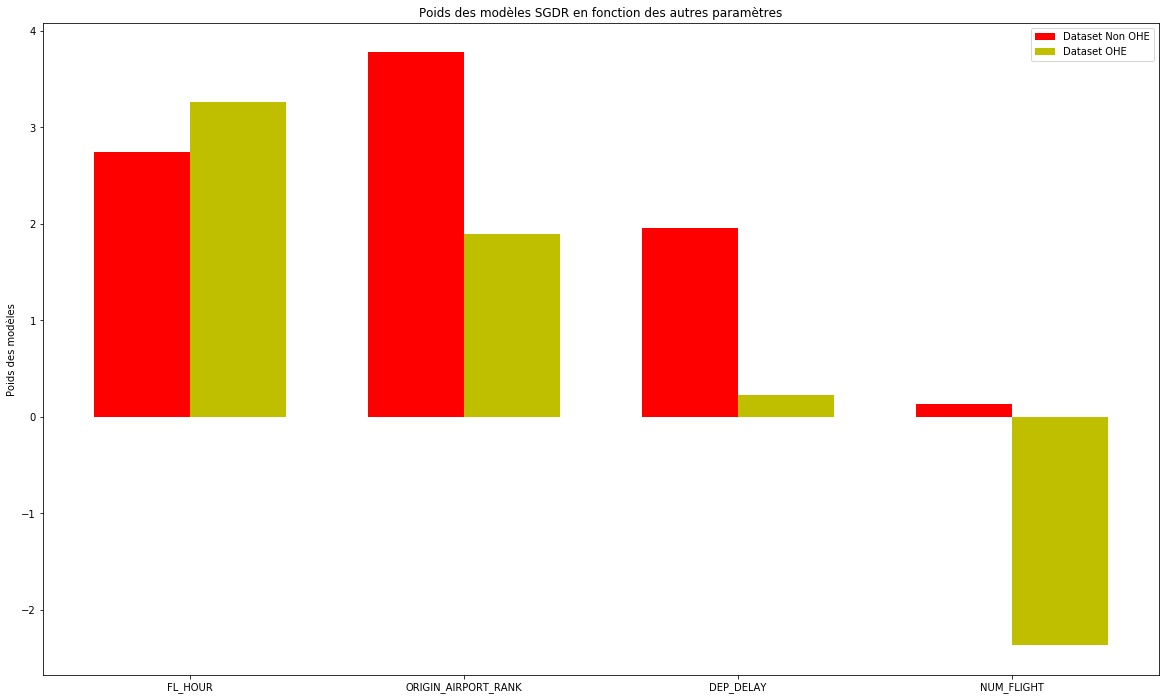

In [42]:
width = 0.35
label = []
x = []
x2 = []
y = []
y2 = []
mid=[]
a = 0
for key, key_ohe, value in zip(model.coef_, model_OHE.coef_, list(df)):
    if value in ["FL_HOUR", "ORIGIN_AIRPORT_RANK", "DEP_DELAY", "NUM_FLIGHT"] :
        label.append(value)
        y.append(key)
        y2.append(key_ohe)
        x.append(a)
        x2.append(a+width)
        mid.append((a+width/2))
        a += 1

# plt.figure(figsize=(20,12))
fig, ax = plt.subplots(figsize=(20,12))
rects1 = ax.bar(x, y, width, color='r', label="Dataset Non OHE")
rects2 = ax.bar(x2, y2, width, color='y', label="Dataset OHE")
ax.set_xticks(mid)
ax.set_xticklabels(label)

plt.legend()
plt.ylabel('Poids des modèles')
plt.title("Poids des modèles SGDR en fonction des autres paramètres")
plt.savefig("img/weight_other.png")
plt.show()

In [43]:
booster.estimator_weights_ 

array([ 4.98532409,  4.81002252,  4.26620337,  2.8442027 ,  1.52233069])

In [44]:
booster.estimator_errors_  

array([ 0.00679113,  0.00808183,  0.01384071,  0.05498176,  0.17911857])

In [45]:
booster.estimators_ 

[SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
        fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
        loss='huber', max_iter=10, n_iter=None, penalty=None, power_t=0.25,
        random_state=981818443, shuffle=True, tol=None, verbose=0,
        warm_start=False),
 SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
        fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
        loss='huber', max_iter=10, n_iter=None, penalty=None, power_t=0.25,
        random_state=1337163725, shuffle=True, tol=None, verbose=0,
        warm_start=False),
 SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
        fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
        loss='huber', max_iter=10, n_iter=None, penalty=None, power_t=0.25,
        random_state=323886239, shuffle=True, tol=None, verbose=0,
        warm_start=False),
 SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
        

In [31]:
matrix = []
for weight, model_ in zip(booster.estimator_weights_ , booster.estimators_ ):
    vecteur = weight * np.array(model_.coef_)
    matrix.append(vecteur)

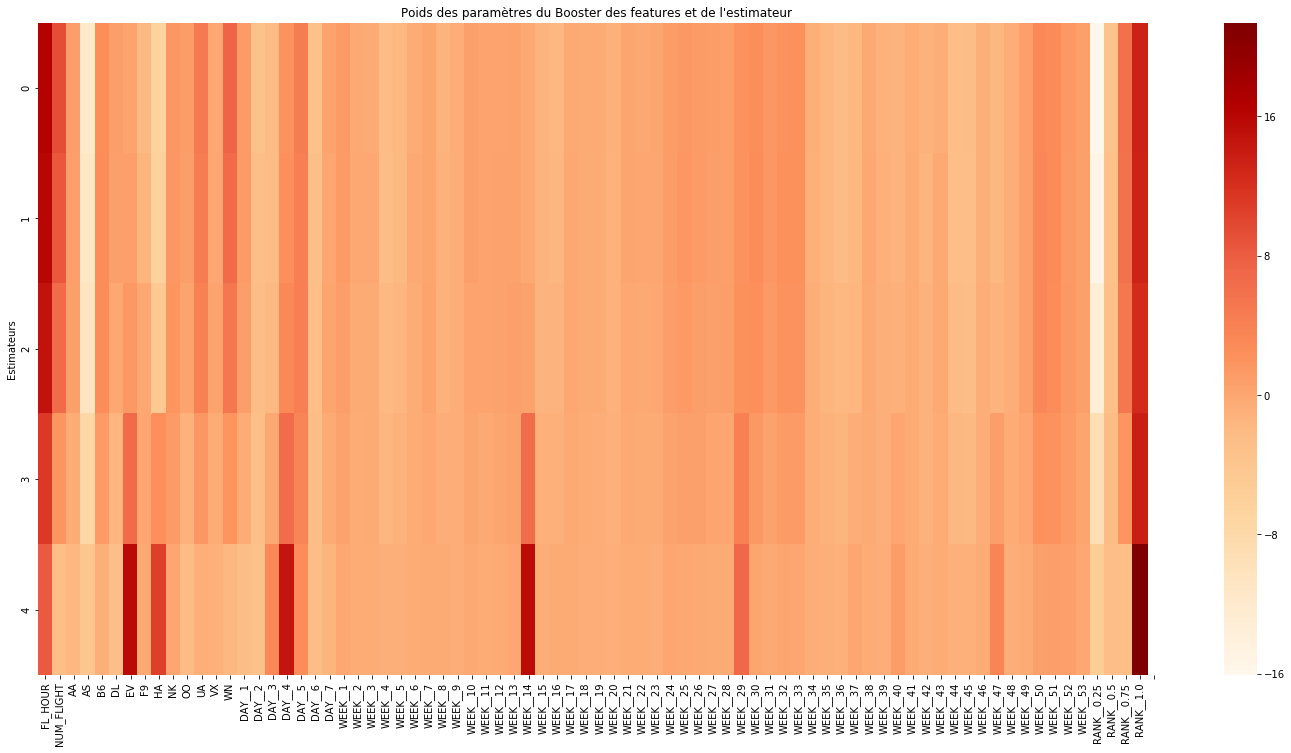

In [32]:
label = [x for i, x in enumerate(list(df_OHE)) if i != 1]
fig, ax = plt.subplots(figsize=(25,12))
ax = sns.heatmap(np.array(matrix), cmap="OrRd")
x_range = [x+0.5 for x in range(len(list(df_OHE)))]
plt.xticks(x_range, label, rotation='vertical')
plt.ylabel('Estimateurs')
plt.title("Poids des paramètres du Booster des features et de l'estimateur")
plt.savefig("img/booster_coeffs.png")
plt.show()

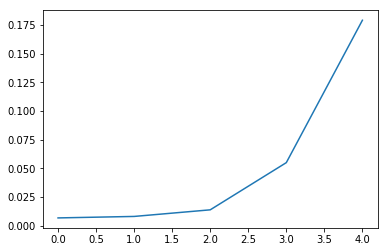

In [46]:
plt.plot(range(5), booster.estimator_errors_ )
plt.show()

## BONUS : Modèle non linéaire

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(250, input_dim=X_train_OHE.shape[1], activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', 'mean_squared_error'])

early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [16]:
model.fit(X_train_OHE, y_train_OHE, epochs=25, batch_size=2000, callbacks=[early_stop], verbose=2)

Epoch 1/25
 - 1s - loss: 8.6996 - mean_absolute_error: 8.6996 - mean_squared_error: 491.7080
Epoch 2/25
 - 1s - loss: 8.6707 - mean_absolute_error: 8.6707 - mean_squared_error: 490.9906
Epoch 3/25
 - 1s - loss: 8.6422 - mean_absolute_error: 8.6422 - mean_squared_error: 488.6729
Epoch 4/25
 - 1s - loss: 8.5945 - mean_absolute_error: 8.5945 - mean_squared_error: 486.3843
Epoch 5/25
 - 1s - loss: 8.5679 - mean_absolute_error: 8.5679 - mean_squared_error: 484.9789
Epoch 6/25
 - 1s - loss: 8.5198 - mean_absolute_error: 8.5198 - mean_squared_error: 482.2488
Epoch 7/25
 - 1s - loss: 8.4950 - mean_absolute_error: 8.4950 - mean_squared_error: 481.6035
Epoch 8/25
 - 1s - loss: 8.4736 - mean_absolute_error: 8.4736 - mean_squared_error: 480.4081
Epoch 9/25
 - 1s - loss: 8.4555 - mean_absolute_error: 8.4555 - mean_squared_error: 479.0322
Epoch 10/25
 - 1s - loss: 8.4501 - mean_absolute_error: 8.4501 - mean_squared_error: 478.4930
Epoch 11/25
 - 1s - loss: 8.4193 - mean_absolute_error: 8.4193 - mean

In [17]:
y_pred_NN = model.predict(X_test_OHE)

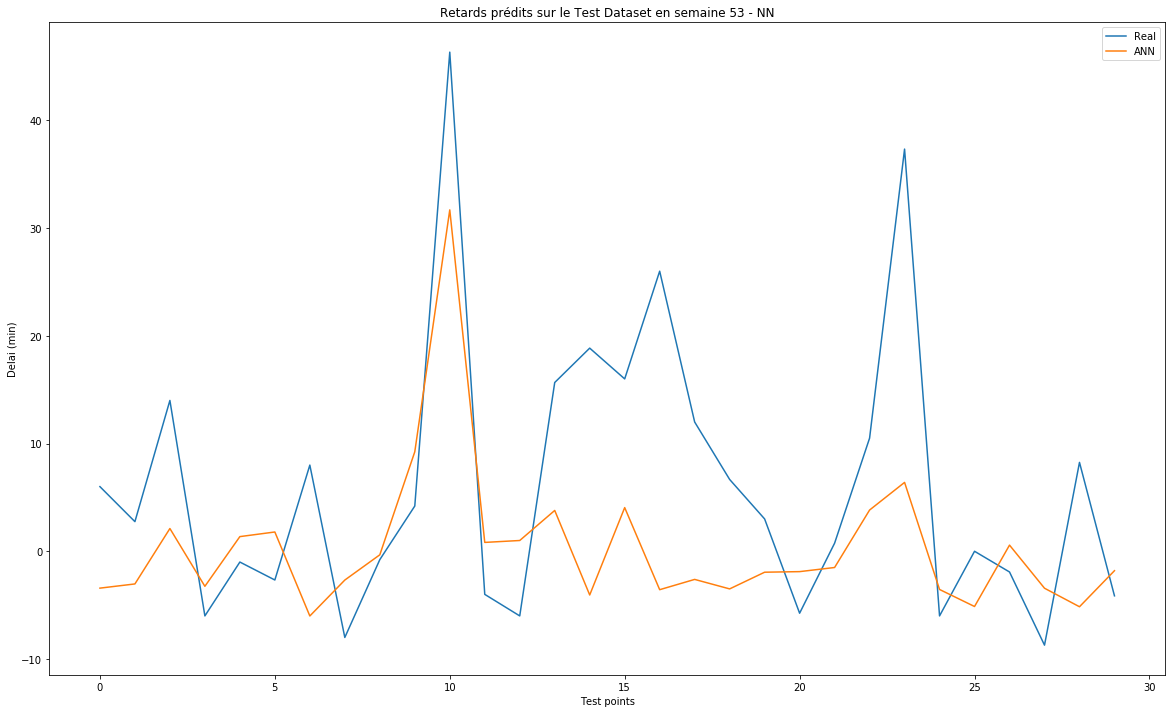

In [19]:
column = list(df_OHE).index("WEEK__53")
index_list = np.where(X_test_OHE[:,column] == 1)[0][:30]
x_range = len(index_list)

plt.figure(figsize=(20,12))
plt.plot(range(x_range), y_test_OHE.reset_index(drop=True).iloc[index_list], label="Real")
plt.plot(range(x_range), y_pred_NN[index_list], label="ANN")
plt.legend()
plt.ylabel("Delai (min)")
plt.xlabel("Test points")
plt.title("Retards prédits sur le Test Dataset en semaine 53 - NN")
plt.savefig("img/predict_december_NN.png")
plt.show()

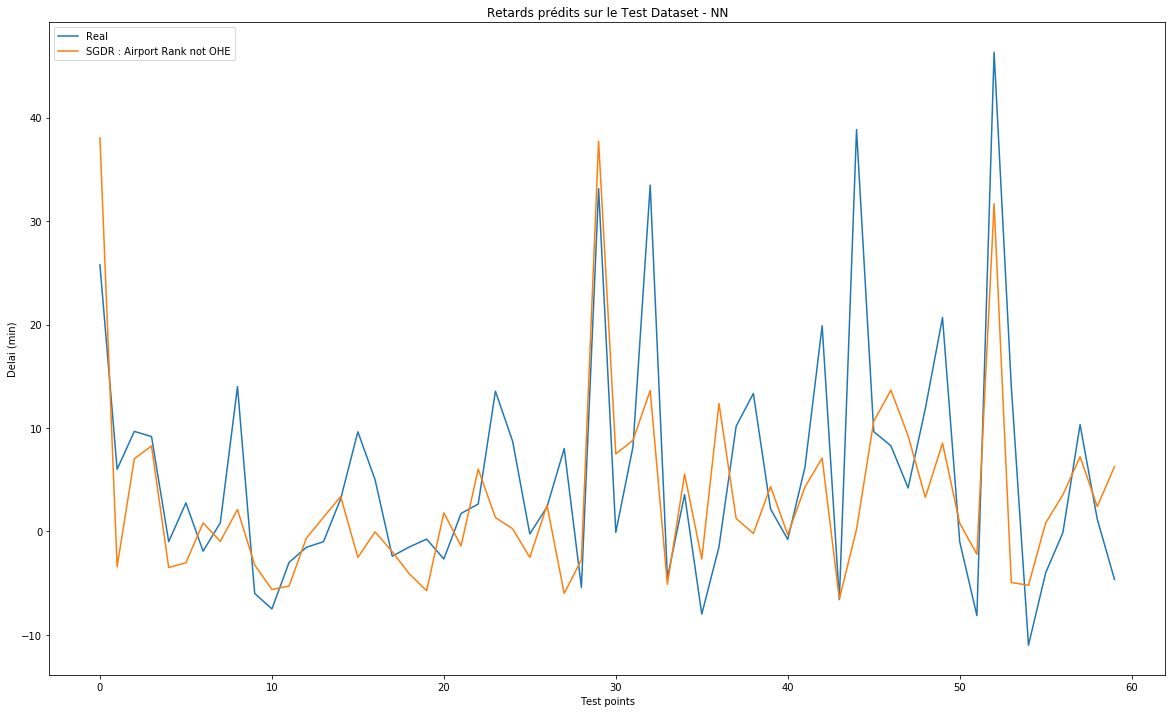

In [21]:
start = 0
width = 60
plt.figure(figsize=(20,12))
plt.plot(range(width), y_test[start:start+width], label="Real")
plt.plot(range(width), y_pred_NN[start:start+width], label="SGDR : Airport Rank not OHE")

plt.legend()
plt.ylabel("Delai (min)")
plt.xlabel("Test points")
plt.title("Retards prédits sur le Test Dataset - NN")
plt.savefig("img/predict_zoom_out_nn.png")
plt.show()

## Export

In [21]:
from sklearn.externals import joblib

joblib.dump(booster, 'prod/model.pkl')

['prod/model.pkl']

Il faut aussi récuperer le nb de vol moyen par aéroport

In [28]:
def to_hour(x):
    if not pd.isnull(x):
        x = int(x)
        if x < 60:
            return 0
        else:
            return int(str(x)[:-2])
        
print("Load Month: 1")
df = pd.read_csv("dataset/lighted/2016_01_light.csv")
for i in range(2, 13):
    print("Load Month:", i)
    df2 = pd.read_csv("dataset/lighted/2016_{:02d}_light.csv".format(i))
    df = df.append(df2)

df["FL_HOUR"] = df["CRS_DEP_TIME"].apply(to_hour)
df = df[["ORIGIN_AIRPORT_ID", "FL_HOUR"]]

Load Month: 1
Load Month: 2
Load Month: 3
Load Month: 4
Load Month: 5
Load Month: 6
Load Month: 7
Load Month: 8
Load Month: 9
Load Month: 10
Load Month: 11
Load Month: 12


In [30]:
df["COUNT"] = 0

In [32]:
df

,ORIGIN_AIRPORT_ID,FL_HOUR,COUNT
0,11298.0,11,0
1,11298.0,11,0
2,11298.0,11,0
3,11298.0,11,0
4,11298.0,11,0
5,11298.0,11,0
6,11298.0,11,0
7,11298.0,11,0
8,11298.0,11,0
9,11298.0,11,0


In [34]:
matrix = df.groupby(["ORIGIN_AIRPORT_ID", "FL_HOUR"]).agg({
    "COUNT" : "count"
})

In [48]:
matrix.reset_index()

,ORIGIN_AIRPORT_ID,FL_HOUR,COUNT
0,15.0,1,1
1,10135.0,5,211
2,10135.0,6,714
3,10135.0,9,31
4,10135.0,10,6
5,10135.0,11,102
6,10135.0,12,190
7,10135.0,13,252
8,10135.0,14,31
9,10135.0,15,18


In [37]:
pivoted = matrix.reset_index().pivot_table(index='ORIGIN_AIRPORT_ID',
                                       columns='FL_HOUR').fillna(0)

In [71]:
pivoted

COUNT                                                   \
FL_HOUR                0      1      2    3    4       5       6        7    
ORIGIN_AIRPORT_ID                                                            
15.0                  0.0    1.0    0.0  0.0  0.0     0.0     0.0      0.0   
10135.0               0.0    0.0    0.0  0.0  0.0   211.0   714.0      0.0   
10136.0               0.0    0.0    0.0  0.0  0.0     0.0     0.0      0.0   
10140.0               0.0    0.0    0.0  0.0  0.0   899.0  2311.0   1049.0   
10141.0               0.0    0.0    0.0  0.0  0.0   347.0     0.0     15.0   
10146.0               0.0    0.0    0.0  0.0  0.0   238.0     9.0     78.0   
10154.0               0.0    0.0    0.0  0.0  0.0     0.0     0.0      0.0   
10155.0               0.0    0.0    0.0  0.0  0.0   309.0     0.0     30.0   
10157.0               0.0    0.0    0.0  0.0  0.0    36.0   330.0      0.0   
10158.0               0.0    0.0    0.0  0.0  0.0     0.0   688.0    628.0   
10165.0               0.0    0.0    0.0  0.0  0.0     0.0     0.0      0.0   
10170.0               0.0    0.0    0.0  0.0  0.0     0.0     0.0      0.0   
10185.0               0.0    0.0    0.0  0.0  0.0   100.0   440.0    116.0   
10208.0               0.0    0.0    0.0  0.0  0.0   241.0   314.0    133.0   
10245.0               0.0    0.0    0.0  0.0  0.0     0.0     0.0      0.0   
10257.0               0.0    0.0    0.0  0.0  0.0   671.0  1422.0    424.0   
10279.0               0.0    0.0    0.0  0.0  0.0   115.0   359.0    177.0   
10299.0            1405.0  773.0  259.0  0.0  0.0   754.0  1114.0    785.0   
10333.0               0.0    0.0    0.0  0.0  0.0   266.0     0.0      0.0   
10372.0               0.0    0.0    0.0  0.0  0.0     0.0     0.0    665.0   
10397.0               0.0    0.0    0.0  0.0  0.0  1162.0  4492.0  12700.0   
10408.0               0.0    0.0    0.0  0.0  0.0   683.0   327.0    192.0   
10423.0               1.0   19.0    0.0  0.0  0.0  1781.0  4626.0   3810.0   
10431.0               0.0    0.0    0.0  0.0  0.0   197.0   304.0    444.0   
10434.0               0.0    0.0    0.0  0.0  0.0   163.0   544.0    144.0   
10469.0               0.0    0.0    0.0  0.0  0.0   112.0   411.0    152.0   
10529.0               0.0    0.0    0.0  0.0  0.0   703.0  2988.0   2193.0   
10551.0               0.0    0.0    0.0  0.0  0.0     0.0     0.0      0.0   
10558.0               0.0    0.0    0.0  0.0  0.0     0.0     0.0      0.0   
10561.0               0.0    0.0    0.0  0.0  0.0   362.0   690.0      0.0   
...                   ...    ...    ...  ...  ...     ...     ...      ...   
14908.0               0.0    0.0    0.0  0.0  0.0     0.0  3245.0   2995.0   
14952.0               0.0    0.0    0.0  0.0  0.0   425.0   158.0      4.0   
14955.0               0.0    0.0    0.0  0.0  0.0     0.0     0.0      0.0   
14960.0               0.0    0.0    0.0  0.0  0.0   275.0     0.0     12.0   
14986.0               0.0    0.0    0.0  0.0  0.0   246.0   140.0    307.0   
15016.0               0.0    0.0    0.0  0.0  0.0  1685.0  3911.0   3966.0   
15024.0               0.0    0.0    0.0  0.0  0.0     0.0     0.0     36.0   
15027.0               0.0    0.0    0.0  0.0  0.0     0.0     0.0      1.0   
15041.0               0.0    0.0    0.0  0.0  0.0     0.0   174.0    231.0   
15070.0               0.0    0.0    0.0  0.0  0.0    43.0    96.0    136.0   
15096.0               0.0    0.0    0.0  0.0  0.0   741.0   599.0    507.0   
15249.0               0.0    1.0    0.0  0.0  0.0   252.0   267.0    258.0   
15304.0               0.0    0.0    0.0  0.0  0.0  1118.0  4118.0   6152.0   
15323.0               0.0    0.0    0.0  0.0  0.0     0.0   268.0    348.0   
15356.0               0.0    0.0    0.0  0.0  0.0     0.0   532.0    160.0   
15370.0               0.0    0.0    0.0  0.0  0.0   634.0  2117.0   1087.0   
15376.0               0.0    0.0    0.0  0.0  0.0   975.0  1966.0   1933.0   
15380.0               0.0    0.0    0.0  0

In [88]:
import pickle

def save_obj(obj, name ):
    with open('prod/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dico = {}
for index, row in pivoted.iterrows():
    dico[index] = row.tolist()

save_obj(dico, "freq_airport")

In [91]:
index = list(df_OHE)
index.remove('DEP_DELAY')

save_obj(index, "index")

In [92]:
index

['FL_HOUR',
 'NUM_FLIGHT',
 'AA',
 'AS',
 'B6',
 'DL',
 'EV',
 'F9',
 'HA',
 'NK',
 'OO',
 'UA',
 'VX',
 'WN',
 'DAY__1',
 'DAY__2',
 'DAY__3',
 'DAY__4',
 'DAY__5',
 'DAY__6',
 'DAY__7',
 'WEEK__1',
 'WEEK__2',
 'WEEK__3',
 'WEEK__4',
 'WEEK__5',
 'WEEK__6',
 'WEEK__7',
 'WEEK__8',
 'WEEK__9',
 'WEEK__10',
 'WEEK__11',
 'WEEK__12',
 'WEEK__13',
 'WEEK__14',
 'WEEK__15',
 'WEEK__16',
 'WEEK__17',
 'WEEK__18',
 'WEEK__19',
 'WEEK__20',
 'WEEK__21',
 'WEEK__22',
 'WEEK__23',
 'WEEK__24',
 'WEEK__25',
 'WEEK__26',
 'WEEK__27',
 'WEEK__28',
 'WEEK__29',
 'WEEK__30',
 'WEEK__31',
 'WEEK__32',
 'WEEK__33',
 'WEEK__34',
 'WEEK__35',
 'WEEK__36',
 'WEEK__37',
 'WEEK__38',
 'WEEK__39',
 'WEEK__40',
 'WEEK__41',
 'WEEK__42',
 'WEEK__43',
 'WEEK__44',
 'WEEK__45',
 'WEEK__46',
 'WEEK__47',
 'WEEK__48',
 'WEEK__49',
 'WEEK__50',
 'WEEK__51',
 'WEEK__52',
 'WEEK__53',
 'RANK__0.25',
 'RANK__0.5',
 'RANK__0.75',
 'RANK__1.0']